In [29]:
#imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

from matplotlib import pyplot as plt
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

In [30]:
from utils.basic_utils import csv_store, csv_ext, numeric_cols
from utils.pricing import dummy_col, px_fwd_ret, get_ind_index, discret_rets
from utils.pricing import rename_col
from utils.fundamental import chain_outlier
from utils.TechnicalDS import TechnicalDS

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.layers import BatchNormalization

In [31]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

### Context data

In [32]:
# context
context = {
    'ml_path': '../ML/',
    'model_name': 'micro_TF.h5',
    'tmp_path': '../tmp/',
    'px_vol_ds': 'universe-px-vol-ds.h5',
    'trained_cols': 'micro_TF_train_cols.npy',
    'look_ahead': 120,
    'look_back': 252*3,
    'load_ds': True,
    'scale': True,
    'test_size': .05,
    'verbose': True,
    's3_path': 'recommend/micro_ML/',
    'units': 300, #850
    'max_iter': 10, #50
    'l2_reg': 0.01,
}

In [33]:
# get latest pricing file from inferece server
# px_close_ds = context['px_vol_ds']
# tmp_path = context['tmp_path']
# os.makedirs(tmp_path, exist_ok=True)
# !scp -i ~/.ssh/qc_infra.pem ubuntu@52.13.205.29:~/inception/tmp/{px_close_ds} {tmp_path}{px_close_ds}

In [34]:
tech_ds = TechnicalDS(
    context['tmp_path'], 
    context['px_vol_ds'], 
    load_ds=True, 
    look_ahead=context['look_ahead'], 
    max_draw_on=True, quantile=0.95)
y_col = tech_ds.ycol_name

51 companies above 6.144x in the last 7.0 years
Target date: 2019-05-22
Loading file quote/csv/2019-05-22
Loading file summary-categories/assetProfile
Sectors: 11, Industries: 136


### Final

In [35]:
def pre_process_ds(context):
    raw_df = tech_ds.stitch_companies_groups()
    print(f'Shape excluding NAs: {raw_df.shape}')
    symbols = raw_df.reset_index().set_index(['symbol']).index
    sector_map = tech_ds.profile.loc[tech_ds.tickers,'sector'].to_dict()
    raw_df.loc[:, 'sector'] = symbols.map(sector_map)
    raw_df = chain_outlier(raw_df, None)
    # basic impute and scaling
    scale_on = context['scale']
    scaler = StandardScaler()
    num_cols = numeric_cols(raw_df)
    if scale_on: raw_df.loc[:, num_cols] = scaler.fit_transform(
        raw_df[num_cols])
    # add categoricals
    raw_df.dropna(subset=['sector'], inplace=True)
    raw_df = dummy_col(raw_df, 'sector', shorten=True)
    return raw_df

In [36]:
def predict_ds(context):
    
    ml_path = context['ml_path']
    model_name = context['model_name']
    trained_cols = context['trained_cols']
    look_back = context['look_back']

    joined_df = pre_process_ds(context)
    joined_df.reset_index(level=1, inplace=True)
    pred_X = joined_df.loc[joined_df.sort_index().index.unique()[-look_back:], :]
    print('pred_X.shape', pred_X.shape)

    # ensure prediction dataset is consistent with trained model
    # save feature order
    train_cols = np.load(ml_path + trained_cols, allow_pickle=True)
    missing_cols = [x for x in train_cols if x not in pred_X.columns]
    if len(missing_cols):
        print(f'Warning missing columns: {missing_cols}')
        for c in missing_cols:
            pred_X[c] = 0

    sorted_cols = list(np.append(train_cols, ['symbol']))
    print('pred_X.shape', pred_X[sorted_cols].shape)

    pred_df = pd.DataFrame()
    pred_df['symbol'] = pred_X.symbol

    # Load model
    fname = ml_path + model_name
    model = load_model(fname)
    print('Loaded', fname)

    preds = model.predict(pred_X[sorted_cols].iloc[:, :-1])
    preds_classes = model.predict_classes(pred_X[sorted_cols].iloc[:, :-1])

    labels = tech_ds.forward_return_labels
    pred_df['pred_class'] = preds_classes
    pred_df['pred_label'] = list(map(lambda x: labels[x], preds_classes))
    probs = np.round(preds, 3)
    # higest prob
    pred_df['confidence'] = [x[np.argmax(x)] for x in probs]
    prob_df = pd.DataFrame(probs, index=pred_df.index, columns=labels)
    pred_df = pd.concat([pred_df, prob_df[labels]], axis=1)
    pred_df.index.name = 'pred_date'

    # store in S3
    s3_path = context['s3_path']
    s3_df = pred_df.reset_index(drop=False)
    rename_col(s3_df, 'index', 'pred_date')
    csv_store(s3_df, s3_path, csv_ext.format(tech_ds.tgt_date))

    return pred_df

#### Predict

In [ ]:
tech_ds.incl_group_feat_dict.keys()
tech_ds.incl_group_feat_dict['PerfRank20']['^MEDI_DEVI']

In [ ]:
tgt = ['^ALL', '^CONS_CYCL', '^MEDI_DIVE']
for k in tech_ds.incl_group_feat_dict.keys():
    print(k)
    print([x for x in tgt if x in list(tech_ds.incl_group_feat_dict[k].columns)])
#     l = list(tech_ds.incl_group_feat_dict[k].columns)
#     print(list(set(tgt).intersection(l)) == tgt)

In [38]:
%%time 
# predict for all
pred_df = predict_ds(context)

OCLHV dataframes
Inverting instruments
Change dataframes
Relative performance dataframes
Relative volume and dollar value dataframes
Realized volatility dataframe
Percentage change stds dataframes
Max draw/pull dataframes
Ranked returns dataframes
Forward return dataframe
Group index
Group percentage changes
Group pct stds
Group performance deltas
% above MA by group
% positive / negative chg stds by group
Group 50 day stds
Group 50 day deltas
Ranked returns dataframes
Dataset columns: Index(['PctChg{p}', 'IntraDayChg', 'OpenGap', 'Pct50MA', 'Pct200MA', 'Pct52WH',
       'Pct52WL', 'PctVol10DA', 'PctVol50DA', 'PctDV10DA', 'PctDV50DA',
       'RollRealVol30', 'PctChgStds{p}', 'MaxDraw120', 'MaxPull120',
       'PerfRank20', 'PerfRank50', 'PerfRank200', 'fwdRet120', '50StdsAll',
       '50StdsSect', '50StdsInd', '200StdsAll', '200StdsSect', '200StdsInd',
       'pctGt50MAAll', 'pctGt50MASect', 'pctGt50MAInd', 'pctGt200MAAll',
       'pctGt200MASect', 'pctGt200MAInd', 'pctPosStdsAll', 'pc

/Users/vveiga/miniconda3/envs/inception/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


pred_X.shape (37044, 61)
Warning missing columns: ['PctChg1', 'PctChg20', 'PctChg50', 'PctChg200', 'PctChgStds1', 'PctChgStds20', 'PctChgStds50', 'PctChgStds200', '^ENER', '^REAL_ESTA', '^UTIL']
pred_X.shape (37044, 60)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Loaded ../ML/micro_TF.h5
Saved recommend/micro_ML/2019-05-22.csv
CPU times: user 1min 47s, sys: 1min 10s, total: 2min 58s
Wall time: 1min 23s


#### Visualize

In [39]:
tech_ds.tickers[:5]

['NFLX', 'BEAT', 'TAL', 'VIPS', 'AAXN']

In [40]:
# recommendation distribution
print('Prediction distribution')
pd.value_counts(pred_df.pred_label) / pd.value_counts(pred_df.pred_label).sum()

Prediction distribution


bear      0.45
bull      0.40
neutral   0.10
long      0.04
short     0.01
Name: pred_label, dtype: float64

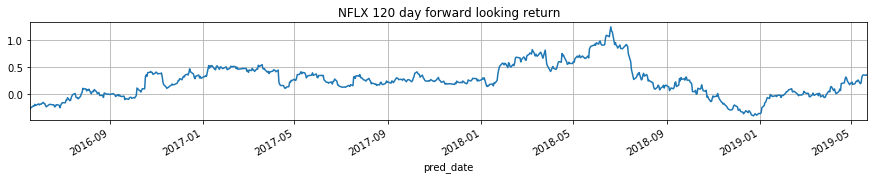

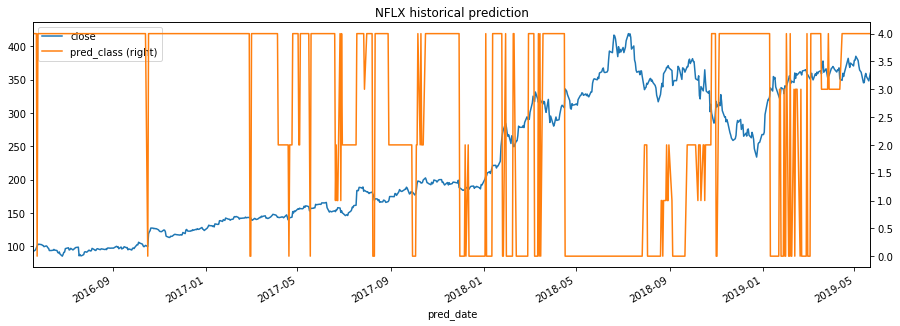

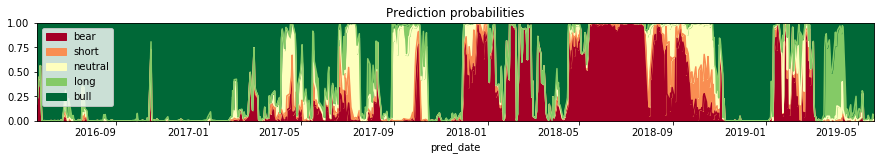

In [42]:
def plot_symbol_hist_pred(pred_symbol, clean_co_px, context, pred_df, labels):
    
    # pred_symbol = random.choice(joined_df.symbol.unique())
    pred_symbol = pred_symbol if pred_symbol is not None else random.choice(joined_df.symbol.unique())
    px_df = clean_co_px[pred_symbol]
    px_df.name = 'close'
    look_ahead = context['look_ahead']
    pct_chg_df = px_df.pct_change(look_ahead)
    pct_chg_df.name = 'pct_chg'

    co_pred = pred_df.loc[pred_df.symbol.isin([pred_symbol]), ['pred_class'] + labels]
    hist_pred = pd.concat([px_df.loc[pred_df.index.unique()], co_pred['pred_class']], axis=1, sort=False)

    # forward looking returns
    pct_chg_df.loc[pred_df.index.unique()].dropna().plot(
        title=f'{pred_symbol} {int(np.mean(context["look_ahead"]))} day forward looking return', 
        figsize=(15, 2), grid=True)

    # historical predictions
    hist_pred.dropna().plot(
        title=f'{pred_symbol} historical prediction', 
        figsize=(15, 5), secondary_y='pred_class')

    # probability distribution
    co_pred[labels].plot.area(
        title='Prediction probabilities', 
        figsize=(15, 2), ylim=(0, 1), cmap='RdYlGn', rot=0)

symbol = 'NFLX'
plot_symbol_hist_pred(
    symbol, tech_ds.clean_px, context, 
    pred_df, tech_ds.forward_return_labels)

In [43]:
pred_df.loc[pred_df.symbol.isin([symbol])].head()

,symbol,pred_class,pred_label,confidence,bear,short,neutral,long,bull
pred_date,,,,,,,,,
2016-05-20,NFLX,4,bull,0.82,0.18,0.00,0.00,0.00,0.82
2016-05-23,NFLX,4,bull,0.56,0.44,0.00,0.00,0.00,0.56
2016-05-24,NFLX,4,bull,0.56,0.43,0.00,0.00,0.00,0.56
2016-05-25,NFLX,0,bear,0.56,0.56,0.00,0.00,0.00,0.44
2016-05-26,NFLX,4,bull,0.80,0.20,0.00,0.00,0.00,0.80


#### AI driven portfolio construction, single period

In [92]:
loss_protection = False # stop losses dont seem to help
max_loss = 0.1
long = True # enable long or short
holding_period = 20 # how many days to hold / rebalance
as_of_date = -20; study_period = -30;
min_confidence = 0.7
max_class_rows = 50
nbr_positions = 20
pred_classes = [3, 4] if long else [0, 1]
period_range = list(range(-holding_period, -pred_df.index.unique().shape[0], -holding_period))

In [93]:
def get_top_predictions(pred_df, as_of_date, min_confidence, max_class_rows):
    """ return top recommendatins by label as of a given date """
    label_mask = (pred_df.pred_label.isin(['bear', 'short', 'long', 'bull'])) \
        & (pred_df.confidence > min_confidence)

    top_pred = pred_df.loc[(pred_df.index == pred_df.index.unique()[as_of_date]) & label_mask]\
        .sort_values(by=['pred_label', 'confidence'], ascending=False)\
        .groupby(by='pred_label').head(max_class_rows)
    
    return top_pred
    
top_pred = get_top_predictions(pred_df, as_of_date, min_confidence, max_class_rows)

In [94]:
def get_study_date_range(pred_df, as_of_date, study_period):
    """ 
    return date range for a study period, as of = prediction, 
    study period = number of days to observe stability of predictions    
    """
    return pred_df.index.unique()[study_period + as_of_date:as_of_date]

study_dates = get_study_date_range(pred_df, as_of_date, study_period)
study_dates

DatetimeIndex(['2019-03-13', '2019-03-14', '2019-03-15', '2019-03-18',
               '2019-03-19', '2019-03-20', '2019-03-21', '2019-03-22',
               '2019-03-25', '2019-03-26', '2019-03-27', '2019-03-28',
               '2019-03-29', '2019-04-01', '2019-04-02', '2019-04-03',
               '2019-04-04', '2019-04-05', '2019-04-08', '2019-04-09',
               '2019-04-10', '2019-04-11', '2019-04-12', '2019-04-15',
               '2019-04-16', '2019-04-17', '2019-04-18', '2019-04-22',
               '2019-04-23', '2019-04-24'],
              dtype='datetime64[ns]', name='pred_date', freq=None)

10 Symbols: ['AMN', 'CNC', 'ILMN', 'VIPS', 'LGND', 'DPZ', 'NOAH', 'TSLA', 'ALGN', 'VG']


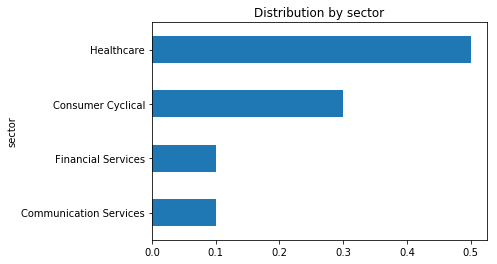

sector                  industry              
Healthcare              Medical Devices           1
                        Medical Care              1
                        Health Care Plans         1
                        Diagnostics & Research    1
                        Biotechnology             1
Financial Services      Asset Management          1
Consumer Cyclical       Specialty Retail          1
                        Restaurants               1
                        Auto Manufacturers        1
Communication Services  Telecom Services          1
Name: address1, dtype: int64


symbol pred_class confidence     
                          count mean
7     AMN          4         30 1.00
11    CNC          4         30 0.96
19   ILMN          4         30 0.95
51   VIPS          4         30 0.86
22   LGND          4         29 0.95
13    DPZ          4         28 0.97
47   TSLA          4         27 0.99
36   NOAH          4         27 0.93
6    ALGN          4         26 0.95
50     VG          4         22 0.79

In [95]:
# historical recomendations for top predictions
def get_most_frequent_preds(pred_df, study_dates, top_pred, pred_classes, treshold=0.6):
    """ return most frequent predictions of a given class for a study period """
    # print(f'Most frequent predictions as of {study_dates[-1]} for classes {pred_classes}')
    last_xdays_pred = pred_df.loc[study_dates]
    last_xdays_pred = last_xdays_pred.loc[
        last_xdays_pred.symbol.isin(list(top_pred.symbol)), 
        ['symbol', 'pred_class', 'confidence']
    ].reset_index()
    most_freq_df = last_xdays_pred.groupby(
        by=['symbol', 'pred_class'])\
        .agg(['count', 'mean']).reset_index()
    
    return most_freq_df.loc[
        most_freq_df['pred_class'].isin(pred_classes)\
        & (most_freq_df[('confidence','count')] > int(len(study_dates) * treshold))]\
        .sort_values(by=('confidence', 'count'), ascending=False)
        
most_freq_df = get_most_frequent_preds(pred_df, study_dates, top_pred, pred_classes, 0.6)
top_pos = most_freq_df.head(nbr_positions)
symbols = list(top_pos.symbol)

print(f'{len(symbols)} Symbols: {symbols}')

by_sect = tech_ds.profile.loc[symbols].groupby(by=['sector']).count().iloc[:,0]\
      .sort_values()
(by_sect / by_sect.sum()).plot.barh(title='Distribution by sector');
plt.show()

by_ind = tech_ds.profile.loc[symbols].groupby(by=['sector', 'industry']).count().iloc[:,0]\
      .sort_values(ascending=False)
print(by_ind.head(20))

top_pos.sort_values(by=[('confidence', 'count'), ('confidence', 'mean')], ascending=False)

In [96]:
def stop_loss(df, long, max_loss):
    truth_df = (df < 1 - max_loss) if long else (df > 1 + max_loss)
    pos = truth_df[truth_df == True]
    if len(pos): df.loc[pos.index[0]:] = df.loc[pos.index[0]]
    return df

idx = tech_ds.clean_px.index.get_loc(study_dates[-1])
prices = tech_ds.clean_px.iloc[idx:idx+holding_period][symbols]
port_index = get_ind_index(prices, tail=holding_period, name='PORT')

if loss_protection:
    port_index = port_index.iloc[:,:-1].apply(stop_loss, args=(long, max_loss)) # stop loss treatment
    port_index = get_ind_index(port_index, tail=holding_period, name='PORT') # recalc portfolio return

print(f'Showing returns from {tech_ds.clean_px.iloc[idx:idx+holding_period].index[[0,-1]]}')
print(f'Portfolio shape: {port_index.shape}')

Showing returns from DatetimeIndex(['2019-04-24', '2019-05-21'], dtype='datetime64[ns]', name='storeDate', freq=None)
Portfolio shape: (20, 11)


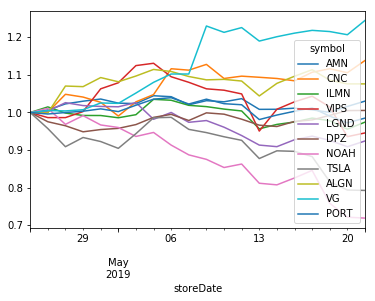

In [97]:
port_index.plot()

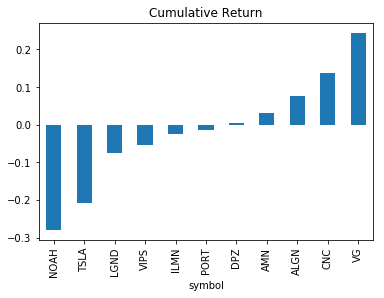

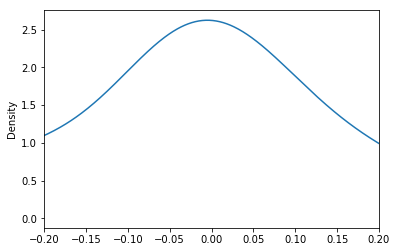

In [98]:
(port_index.iloc[-1] - 1).sort_values().plot.bar(title='Cumulative Return'); plt.show()
(port_index.iloc[-1] - 1).plot.kde(xlim=(-.2,0.2));

In [99]:
# cumulative returns for a given portfolio
port_index.iloc[-1].describe()

count   11.00
mean     0.99
std      0.15
min      0.72
25%      0.93
50%      0.99
75%      1.05
max      1.24
Name: 2019-05-21 00:00:00, dtype: float64

In [100]:
port_index.tail()

symbol,AMN,CNC,ILMN,VIPS,LGND,DPZ,NOAH,TSLA,ALGN,VG,PORT
storeDate,,,,,,,,,,,
2019-05-15,1.01,1.08,0.97,1.03,0.93,0.98,0.83,0.90,1.10,1.21,1.00
2019-05-16,1.01,1.11,0.99,1.04,0.94,0.98,0.85,0.88,1.11,1.22,1.01
2019-05-17,1.00,1.12,0.98,1.01,0.93,0.99,0.76,0.82,1.09,1.22,0.99
2019-05-20,1.02,1.11,0.96,0.94,0.91,1.01,0.72,0.79,1.08,1.21,0.97
2019-05-21,1.03,1.14,0.97,0.95,0.92,1.01,0.72,0.79,1.08,1.24,0.99


#### Backtesting experiment, historical periods

In [101]:
# What are the best portfolios and how do they perform?
super_list = []; symbol_list = []
for as_of_date in period_range:

    top_pred = get_top_predictions(pred_df, as_of_date, min_confidence, max_class_rows)
    study_dates = get_study_date_range(pred_df, as_of_date, study_period)
    most_freq_df = get_most_frequent_preds(pred_df, study_dates, top_pred, pred_classes, 0.6)
    top_pos = most_freq_df.head(nbr_positions)
    symbols = list(top_pos.symbol)
    
    if len(symbols) > 3:
        idx = tech_ds.clean_px.index.get_loc(study_dates[-1])
        prices = tech_ds.clean_px.iloc[idx:idx+holding_period][symbols]
        port_index = get_ind_index(prices, tail=holding_period, name='PORT')
        
        if loss_protection:
            port_index = port_index.iloc[:,:-1].apply(stop_loss, args=(long, max_loss)) # stop loss treatment
            port_index = get_ind_index(port_index, tail=holding_period, name='PORT') # recalc portfolio return
        # print(f'Showing returns from {clean_co_px.iloc[idx:idx+holding_period].index[[0,-1]]}')
        
        exp = port_index.iloc[-1].describe()
        exp['offset_start'] = as_of_date
        exp['as_of_date'] = str(study_dates[-1])
        exp['study_period'] = study_period
        exp['end_date'] = str(port_index.index[-1])
        symbol_list.append(symbols)
        super_list.append(exp)
        
hist_ports = pd.concat(super_list, axis=1).T

Summary for 37 experiment LONG periods
48 unique symbols


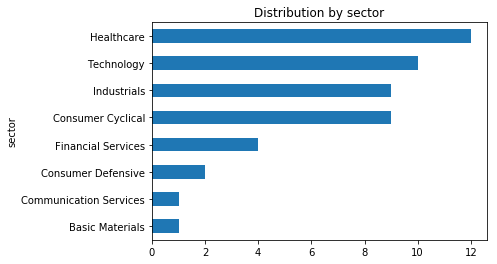

sector                  industry                           
Healthcare              Diagnostics & Research                 3
                        Medical Care                           3
Consumer Cyclical       Media - Diversified                    3
                        Specialty Retail                       3
Industrials             Business Services                      3
                        Airlines                               2
                        Aerospace & Defense                    2
Healthcare              Biotechnology                          2
Technology              Software - Application                 2
Healthcare              Medical Devices                        2
Financial Services      Capital Markets                        2
Technology              Electronic Gaming & Multimedia         2
                        Semiconductors                         2
Consumer Defensive      Education & Training Services          1
Consumer Cyclical       Restau

In [102]:
# Descriptive stats
print(f'Summary for {len(period_range)} experiment {"LONG" if long else "SHORT"} periods')
unique_symbols = set(np.concatenate(symbol_list))
print(f'{len(unique_symbols)} unique symbols')

by_sect = tech_ds.profile.loc[unique_symbols].groupby(by=['sector']).count().iloc[:,0]\
      .sort_values()
by_sect.plot.barh(title='Distribution by sector');
plt.show()

by_ind = tech_ds.profile.loc[unique_symbols].groupby(by=['sector', 'industry']).count().iloc[:,0]\
      .sort_values(ascending=False)
by_ind.head(20)

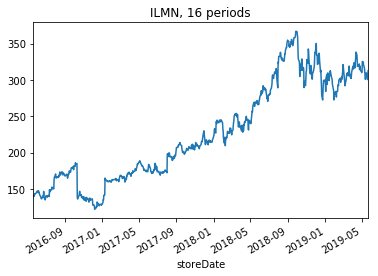

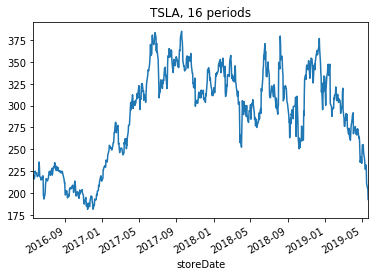

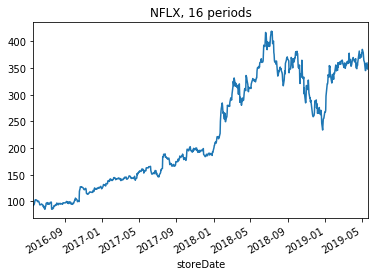

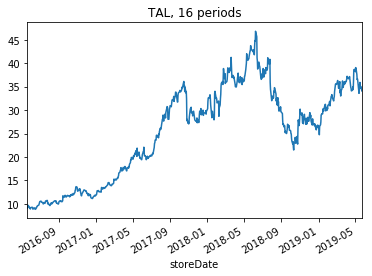

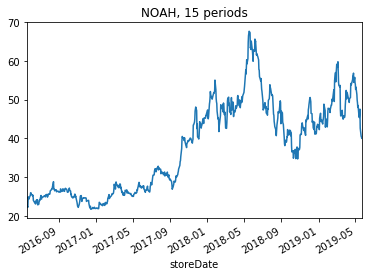

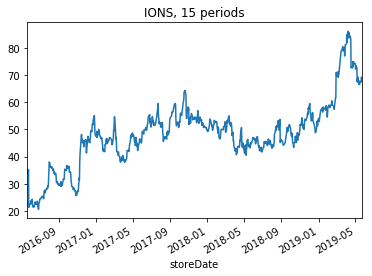

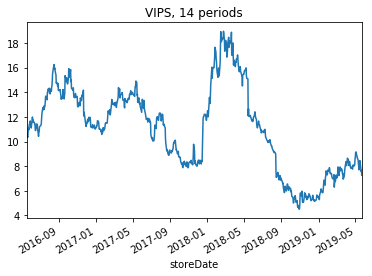

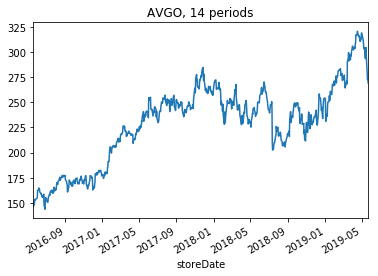

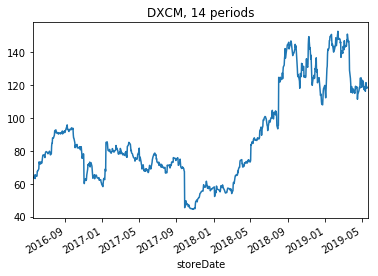

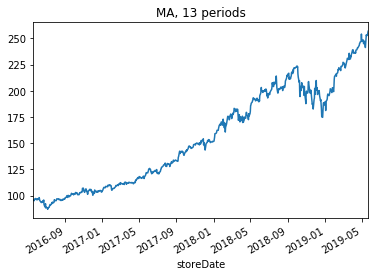

In [103]:
# Most common recommendations
from collections import Counter
pos_freq = Counter(np.concatenate(symbol_list)).most_common()
for t in pos_freq[:10]: 
    tech_ds.clean_px[t[0]].tail(252*3)\
    .plot(title=f'{t[0]}, {t[1]} periods'); plt.show()

In [104]:
mkt_cap_cuts = [0, 0.3, 2, 10, 300, 5000]
mkt_cap_labels = ['micro', 'small', 'mid', 'large', 'mega']

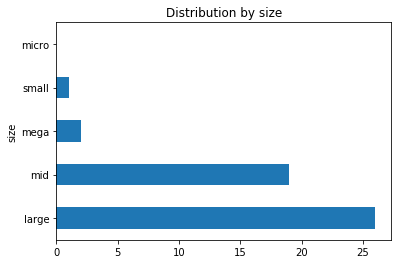

In [105]:
size_df = tech_ds.quotes.loc[unique_symbols, ['marketCap']] / 10**9
size_df['size'] = discret_rets(size_df.marketCap, mkt_cap_cuts, mkt_cap_labels)
size_df.groupby(by=['size']).count().iloc[:,0].sort_values(ascending=False).plot.barh(title='Distribution by size');

Long CAGR: 0.61


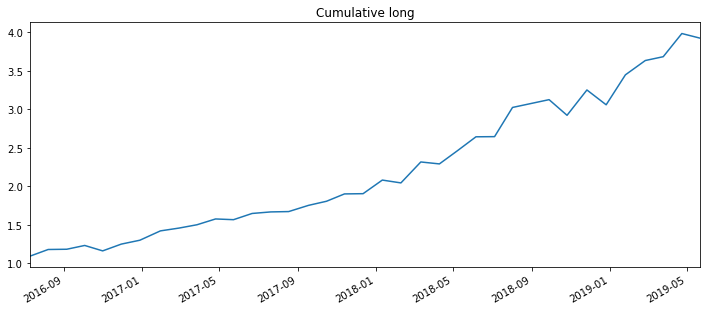

In [106]:
hist_ports.sort_index(inplace=True)
years = (hist_ports.index[-1] - hist_ports.index[0]).days / 365
if long:
    mean_ret = pd.DataFrame()
    mean_ret['long'] = hist_ports['mean'].sort_index()
    mean_ret['long'].cumprod().plot(title='Cumulative long', figsize=(12,5));
    print(f'Long CAGR: {round((mean_ret["long"].cumprod().iloc[-1] ** (1/years) - 1), 2)}')
else:
    mean_ret['short'] = hist_ports['mean'].sort_index()
    mean_ret['short'].cumprod().plot(title='Cumulative short', figsize=(12,5));
    print(f'Short CAGR: {round((mean_ret["short"].cumprod().iloc[-1] ** (1/years) - 1), 2)}')
if 'long' in mean_ret.columns and 'short' in mean_ret.columns:
    mean_ret['ls'] = (mean_ret['long'] - mean_ret['short'] + 1)
    mean_ret.cumprod().plot(title='Long/Short', figsize=(12,5))          
    print(f'L/S CAGR: {(mean_ret["ls"].cumprod().iloc[-1] ** (1/years) - 1)}')

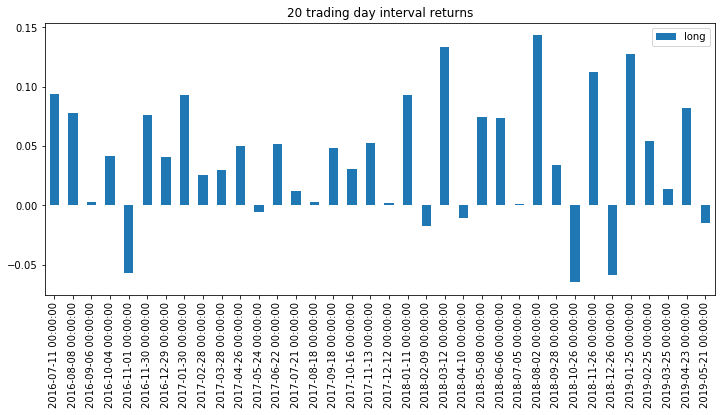

In [107]:
(mean_ret-1).plot(
    title=f'{holding_period} trading day interval returns', 
    kind='bar', figsize=(12,5))

In [108]:
def calc_monthly_ret(l_w, mean_ret):
    monthly_ret = (
        (mean_ret['long'] - 1).mul(l_w) - 
        (mean_ret['short'] - 1).mul(1 - l_w) + 1)
    mix_df = monthly_ret.infer_objects().describe()
    mix_df['l'] = l_w
    mix_df['s'] = 1 - l_w
    return monthly_ret, mix_df

In [109]:
# optimal L/S mix
super_list = []
series = np.arange(0.4, 1.2, 0.05)
if 'short' in mean_ret.columns:
    for l_w in series:
        monthly_ret, mix_df = calc_monthly_ret(l_w, mean_ret)
        super_list.append(mix_df)
        monthly_ret.cumprod().plot()
    scenarios = pd.concat(super_list, axis=1).T
    opt_wgt = series[np.argmax(((scenarios['mean'] - 1) / scenarios['std']))]
    
    # expected long-term return at optimal L/S mix
    monthly_ret, _ = calc_monthly_ret(opt_wgt, mean_ret)
    print(f'Expected return = {round(monthly_ret.cumprod().iloc[-1] ** (1/years) - 1, 2)*100}% at {round(opt_wgt, 2)} long {round(1 - opt_wgt, 2)} short')
    monthly_ret.cumprod().plot();

In [110]:
hist_ports.infer_objects()['mean'].describe()

count   36.00
mean     1.04
std      0.05
min      0.93
25%      1.00
50%      1.04
75%      1.08
max      1.14
Name: mean, dtype: float64

In [111]:
hist_ports.infer_objects().describe()

,count,mean,std,min,25%,50%,75%,max,offset_start,study_period
count,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00
mean,13.36,1.04,0.08,0.89,1.00,1.04,1.08,1.20,-385.00,-30.00
std,4.24,0.05,0.03,0.09,0.06,0.05,0.05,0.11,217.38,0.00
min,5.00,0.93,0.04,0.72,0.84,0.93,0.97,1.03,-740.00,-30.00
25%,11.00,1.00,0.07,0.81,0.97,1.01,1.04,1.13,-565.00,-30.00
50%,13.00,1.04,0.08,0.88,0.99,1.04,1.08,1.19,-390.00,-30.00
75%,17.00,1.08,0.10,0.95,1.03,1.08,1.12,1.24,-210.00,-30.00
max,21.00,1.14,0.17,1.03,1.14,1.16,1.18,1.62,-20.00,-30.00


In [112]:
hist_ports.sort_values(by='offset_start')

,count,mean,std,min,25%,50%,75%,max,offset_start,as_of_date,study_period,end_date
2016-07-11,21.00,1.09,0.06,1.00,1.05,1.09,1.13,1.25,-740.00,2016-06-13 00:00:00,-30,2016-07-11 00:00:00
2016-08-08,15.00,1.08,0.12,0.92,0.99,1.08,1.12,1.41,-720.00,2016-07-12 00:00:00,-30,2016-08-08 00:00:00
2016-09-06,11.00,1.00,0.10,0.81,0.98,1.02,1.04,1.20,-700.00,2016-08-09 00:00:00,-30,2016-09-06 00:00:00
2016-10-04,10.00,1.04,0.08,0.94,1.00,1.04,1.05,1.18,-680.00,2016-09-07 00:00:00,-30,2016-10-04 00:00:00
2016-11-01,11.00,0.94,0.10,0.75,0.89,0.94,0.99,1.16,-660.00,2016-10-05 00:00:00,-30,2016-11-01 00:00:00
2016-11-30,17.00,1.08,0.17,0.87,0.98,1.05,1.11,1.62,-640.00,2016-11-02 00:00:00,-30,2016-11-30 00:00:00
2016-12-29,11.00,1.04,0.08,0.92,0.97,1.04,1.07,1.18,-620.00,2016-12-01 00:00:00,-30,2016-12-29 00:00:00
2017-01-30,12.00,1.09,0.08,0.94,1.04,1.10,1.14,1.24,-600.00,2016-12-30 00:00:00,-30,2017-01-30 00:00:00
2017-02-28,17.00,1.03,0.08,0.79,0.99,1.04,1.06,1.14,-580.00,2017-01-31 00:00:00,-30,2017-02-28 00:00:00
2017-03-28,11.00,1.03,0.04,0.99,1.00,1.02,1.04,1.11,-560.00,2017-03-01 00:00:00,-30,2017-03-28 00:00:00
